In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

## Initialization

In [ ]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.CenterCrop(28)])

mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])

L = 32 # group size

cifar_trainset = torchvision.datasets.CIFAR10(root='./cifar', train=True,
                                              download=True, transform=cifar_transform)
cifar_testset = torchvision.datasets.CIFAR10(root='./cifar', train=False,
                                             download=True, transform=cifar_transform)

mnist_trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                            download=True, transform=mnist_transform)
mnist_testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                           download=True, transform=mnist_transform)

#################################### To Do (2 pts) #############################
# Define trainloader and testloader with given batch size.
# Set shuffle parameter to True for trainloader and False for testloader.
################################################################################

cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=L, shuffle=True)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=L, shuffle=False)

mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=L, shuffle=True)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=L, shuffle=False)

##################################### End ######################################

device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')

100%|██████████| 170498071/170498071 [00:13<00:00, 12339296.43it/s]


Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


100%|██████████| 9912422/9912422 [00:00<00:00, 343646360.22it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 116926345.39it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 174820308.31it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4437579.49it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = torch.softmax(x, dim=1)
        return output

## differentially private SGD

In [ ]:

def evaluate(model, dataloader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return 100 * correct / total


In [ ]:
criterion = nn.CrossEntropyLoss()
lr=0.001

In [ ]:
def DP_SGD(model, trainloader, testloader, num_epochs, criterion, lr, sigma, C):
    """
    sigma: noise scale
    C: gradient norm bound
    """
                  #################################### To Do (16 pts) ##########################

    train_accuracy = []
    test_accuracy = []

    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0

        for batch in trainloader:
            for param in model.parameters():
                param.accumulated_grads = []

            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            for param in model.parameters():
                clip_grad_norm_(param, max_norm=C)
                param.accumulated_grads.append(param.grad)

            with torch.no_grad():
                for param in model.parameters():
                  grad = torch.stack(param.accumulated_grads)
                  noisy_grads = torch.mean(grad, dim=0) + torch.randn_like(param) * sigma * C
                  param.grad.data = noisy_grads
                  param -= lr * param.grad

            _, train_predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (train_predicted == labels).sum().item()

        train_accuracy.append(100 * train_correct / train_total)

        test_acc = evaluate(model, testloader)
        test_accuracy.append(test_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[-1]:.2f}%, Test Acc: {test_acc:.2f}%")

    return train_accuracy, test_accuracy


## Evaluation
Now, we want to test this algorithm on CIFAR10 and MNIST datasets.

### Effect of $\sigma$ (and $\epsilon$) (6 pts)
Plot accuracy vs. epoch for various noise scale $\sigma = 2, 4, 8$ for both datasets. Plot both training and testing accuracy.

Change the code above if needed.


Noise Scale: 2
Epoch 1: Train Acc: 25.99%, Test Acc: 33.46%
Epoch 2: Train Acc: 32.15%, Test Acc: 33.63%
Epoch 3: Train Acc: 38.01%, Test Acc: 46.46%
Epoch 4: Train Acc: 50.34%, Test Acc: 57.99%
Epoch 5: Train Acc: 61.40%, Test Acc: 63.62%
Epoch 6: Train Acc: 63.88%, Test Acc: 64.76%
Epoch 7: Train Acc: 64.71%, Test Acc: 65.35%
Epoch 8: Train Acc: 66.49%, Test Acc: 71.27%
Epoch 9: Train Acc: 71.90%, Test Acc: 73.66%
Epoch 10: Train Acc: 73.27%, Test Acc: 74.80%

Noise Scale: 4
Epoch 1: Train Acc: 10.90%, Test Acc: 19.20%
Epoch 2: Train Acc: 18.67%, Test Acc: 22.69%
Epoch 3: Train Acc: 27.67%, Test Acc: 32.66%
Epoch 4: Train Acc: 33.47%, Test Acc: 36.19%
Epoch 5: Train Acc: 37.18%, Test Acc: 38.12%
Epoch 6: Train Acc: 43.03%, Test Acc: 49.67%
Epoch 7: Train Acc: 55.25%, Test Acc: 57.49%
Epoch 8: Train Acc: 57.26%, Test Acc: 59.05%
Epoch 9: Train Acc: 58.20%, Test Acc: 58.40%
Epoch 10: Train Acc: 59.26%, Test Acc: 60.85%

Noise Scale: 8
Epoch 1: Train Acc: 12.69%, Test Acc: 16.22%
Epoch

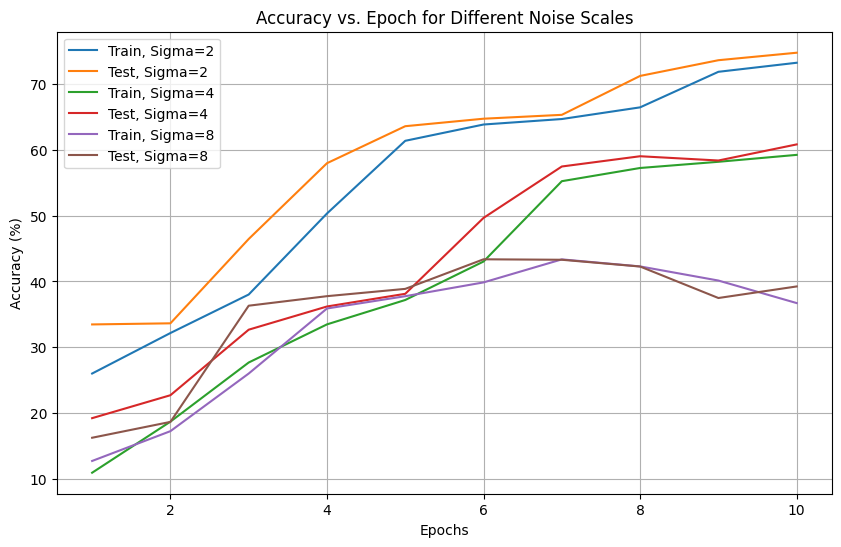

In [ ]:
#Mnist dataset
noise_scales = [2,4,8]

model = Net().to(device)

num_epochs = 10
C = 0.1

train_acc_list = []
test_acc_list = []

for sigma in noise_scales:
    print(f"\nNoise Scale: {sigma}")
    criterion = nn.CrossEntropyLoss()
    model = Net().to(device)

    train_acc, test_acc = DP_SGD(model, mnist_trainloader,mnist_testloader,num_epochs, criterion, lr, sigma, C)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for i in range(len(noise_scales)):
    plt.plot(epochs, train_acc_list[i], label=f"Train, Sigma={noise_scales[i]}")
    plt.plot(epochs, test_acc_list[i], label=f"Test, Sigma={noise_scales[i]}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch for Different Noise Scales")
plt.legend()
plt.grid(True)
plt.show()


Noise Scale: 2
Epoch 1: Train Acc: 9.94%, Test Acc: 10.62%
Epoch 2: Train Acc: 15.44%, Test Acc: 16.80%
Epoch 3: Train Acc: 16.90%, Test Acc: 15.29%
Epoch 4: Train Acc: 16.00%, Test Acc: 15.84%
Epoch 5: Train Acc: 15.22%, Test Acc: 16.25%
Epoch 6: Train Acc: 16.38%, Test Acc: 17.44%
Epoch 7: Train Acc: 15.85%, Test Acc: 15.25%
Epoch 8: Train Acc: 15.82%, Test Acc: 16.69%
Epoch 9: Train Acc: 17.07%, Test Acc: 16.47%
Epoch 10: Train Acc: 16.08%, Test Acc: 15.16%

Noise Scale: 4
Epoch 1: Train Acc: 10.39%, Test Acc: 13.32%
Epoch 2: Train Acc: 11.76%, Test Acc: 11.96%
Epoch 3: Train Acc: 11.21%, Test Acc: 12.68%
Epoch 4: Train Acc: 12.95%, Test Acc: 13.94%
Epoch 5: Train Acc: 13.57%, Test Acc: 14.44%
Epoch 6: Train Acc: 13.49%, Test Acc: 14.02%
Epoch 7: Train Acc: 12.86%, Test Acc: 13.13%
Epoch 8: Train Acc: 11.36%, Test Acc: 11.08%
Epoch 9: Train Acc: 11.49%, Test Acc: 11.07%
Epoch 10: Train Acc: 11.07%, Test Acc: 11.06%

Noise Scale: 8
Epoch 1: Train Acc: 9.40%, Test Acc: 7.52%
Epoch 2:

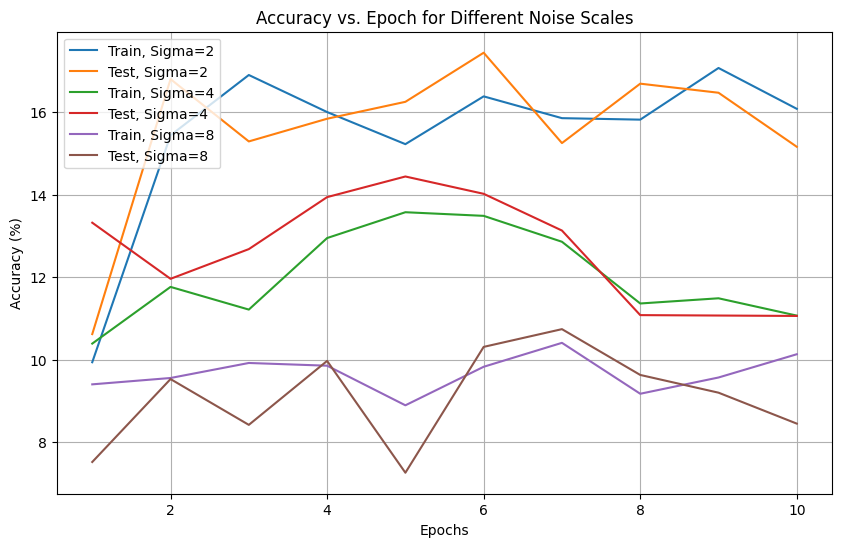

In [ ]:
#Cifar dataset
noise_scales = [2, 4, 8]


model = Net().to(device)

num_epochs = 10
lr = 0.001
C = 1.0

train_acc_list = []
test_acc_list = []

for sigma in noise_scales:
    print(f"\nNoise Scale: {sigma}")
    criterion = nn.CrossEntropyLoss()
    model = Net().to(device)

    train_acc, test_acc = DP_SGD(model, cifar_trainloader, cifar_testloader,num_epochs, criterion, lr, sigma, C)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for i in range(len(noise_scales)):
    plt.plot(epochs, train_acc_list[i], label=f"Train, Sigma={noise_scales[i]}")
    plt.plot(epochs, test_acc_list[i], label=f"Test, Sigma={noise_scales[i]}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch for Different Noise Scales")
plt.legend()
plt.grid(True)
plt.show()

### Effect of $\epsilon, \delta$ (6 pts)
Plot accuracy vs. $\epsilon$ (according to formulas in the lectures) in range $(10^{-1}, 10)$ for $\delta=10^{-i}, i\in\{2, 3, 4, 5\}$ for both datasets.


Delta: 0.01, Epsilon: 0.1
Epoch 1: Train Acc: 10.16%, Test Acc: 10.14%
Epoch 2: Train Acc: 9.02%, Test Acc: 11.47%
Epoch 3: Train Acc: 11.20%, Test Acc: 12.62%
Epoch 4: Train Acc: 14.34%, Test Acc: 15.13%
Epoch 5: Train Acc: 13.71%, Test Acc: 14.47%
Epoch 6: Train Acc: 12.10%, Test Acc: 11.83%
Epoch 7: Train Acc: 10.63%, Test Acc: 10.11%
Epoch 8: Train Acc: 9.80%, Test Acc: 9.21%
Epoch 9: Train Acc: 10.19%, Test Acc: 10.08%
Epoch 10: Train Acc: 11.48%, Test Acc: 13.23%

Delta: 0.01, Epsilon: 0.5
Epoch 1: Train Acc: 10.09%, Test Acc: 9.60%
Epoch 2: Train Acc: 11.21%, Test Acc: 13.20%
Epoch 3: Train Acc: 9.05%, Test Acc: 6.35%
Epoch 4: Train Acc: 8.01%, Test Acc: 9.60%
Epoch 5: Train Acc: 9.96%, Test Acc: 10.96%
Epoch 6: Train Acc: 8.96%, Test Acc: 5.89%
Epoch 7: Train Acc: 7.11%, Test Acc: 9.17%
Epoch 8: Train Acc: 8.06%, Test Acc: 8.10%
Epoch 9: Train Acc: 7.28%, Test Acc: 7.47%
Epoch 10: Train Acc: 7.89%, Test Acc: 8.31%

Delta: 0.01, Epsilon: 1
Epoch 1: Train Acc: 28.38%, Test Acc: 

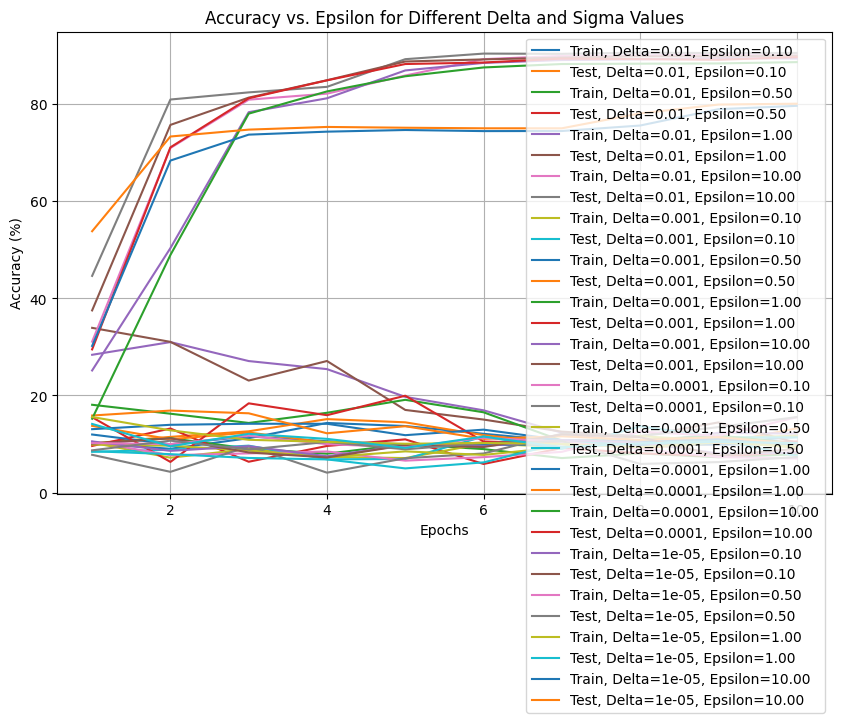

In [ ]:
#Mnist
deltas = [10**(-i) for i in range(2, 6)]
epsilons = [0.1, 0.5, 1, 10] #Due to the Time Consuming property of all values

model = Net().to(device)
num_epochs = 10
lr = 0.001
C = 1.0

train_acc_list = []
test_acc_list = []

# Train and evaluate the model for each epsilon value
for delta in deltas:
    for epsilon in epsilons:
        print(f"\nDelta: {delta}, Epsilon: {epsilon}")
        criterion = nn.CrossEntropyLoss()
        model = Net().to(device)

        sigma = np.sqrt(-2 * np.log(delta)) / epsilon

        train_acc, test_acc = DP_SGD(model, mnist_trainloader, mnist_testloader, num_epochs, criterion, lr, sigma, C)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    for j, epsilon in enumerate(epsilons):
        idx = i * len(epsilons) + j
        plt.plot(epochs, train_acc_list[idx], label=f"Train, Delta={delta}, Epsilon={epsilon:.2f}")
        plt.plot(epochs, test_acc_list[idx], label=f"Test, Delta={delta}, Epsilon={epsilon:.2f}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epsilon for Different Delta and Sigma Values")
plt.legend()
plt.grid(True)
plt.show()


Delta: 0.01, Epsilon: 0.1
Epoch 1: Train Acc: 10.81%, Test Acc: 8.85%
Epoch 2: Train Acc: 9.28%, Test Acc: 9.24%
Epoch 3: Train Acc: 10.08%, Test Acc: 10.26%
Epoch 4: Train Acc: 9.07%, Test Acc: 8.48%
Epoch 5: Train Acc: 9.26%, Test Acc: 9.67%
Epoch 6: Train Acc: 8.93%, Test Acc: 9.77%
Epoch 7: Train Acc: 9.52%, Test Acc: 9.77%
Epoch 8: Train Acc: 9.88%, Test Acc: 9.64%
Epoch 9: Train Acc: 9.49%, Test Acc: 9.02%
Epoch 10: Train Acc: 9.23%, Test Acc: 9.56%

Delta: 0.01, Epsilon: 0.5
Epoch 1: Train Acc: 9.95%, Test Acc: 9.48%
Epoch 2: Train Acc: 9.75%, Test Acc: 9.92%
Epoch 3: Train Acc: 10.78%, Test Acc: 10.57%
Epoch 4: Train Acc: 10.59%, Test Acc: 10.64%
Epoch 5: Train Acc: 10.28%, Test Acc: 8.86%
Epoch 6: Train Acc: 8.34%, Test Acc: 7.77%
Epoch 7: Train Acc: 9.23%, Test Acc: 9.25%
Epoch 8: Train Acc: 8.72%, Test Acc: 8.19%
Epoch 9: Train Acc: 8.82%, Test Acc: 9.18%
Epoch 10: Train Acc: 10.51%, Test Acc: 11.85%

Delta: 0.01, Epsilon: 1
Epoch 1: Train Acc: 12.81%, Test Acc: 14.99%
Epoc

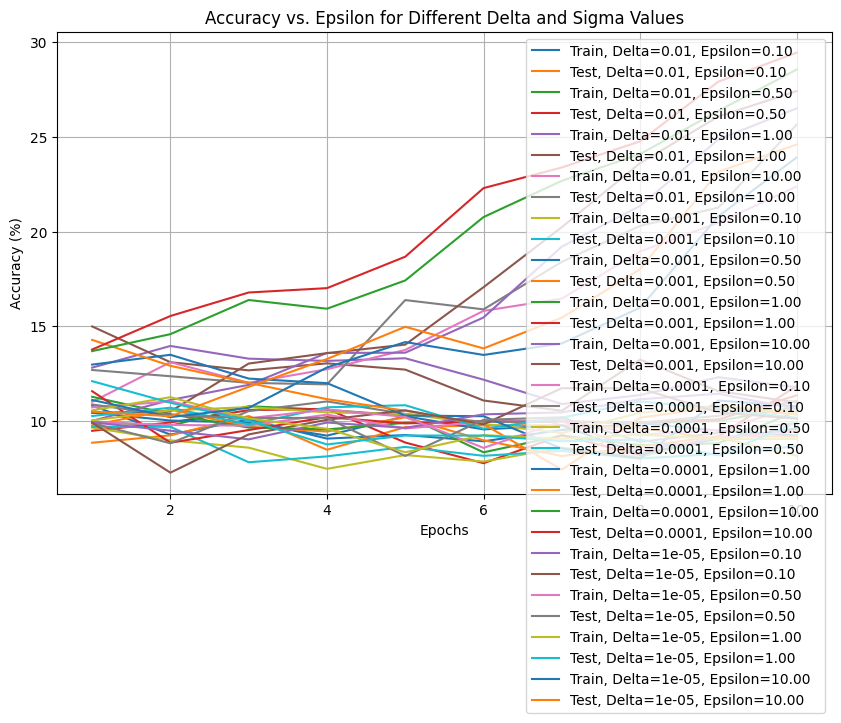

In [ ]:
#Cifar
deltas = [10**(-i) for i in range(2, 6)]
epsilons = [0.1, 0.5, 1, 10] #Due to the Time Consuming property of all values

model = Net().to(device)
num_epochs = 10
lr = 0.001
C = 1.0

train_acc_list = []
test_acc_list = []

# Train and evaluate the model for each epsilon value
for delta in deltas:
    for epsilon in epsilons:
        print(f"\nDelta: {delta}, Epsilon: {epsilon}")
        criterion = nn.CrossEntropyLoss()
        model = Net().to(device)

        sigma = np.sqrt(-2 * np.log(delta)) / epsilon

        train_acc, test_acc = DP_SGD(model, cifar_trainloader, cifar_testloader, num_epochs, criterion, lr, sigma, C)

        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    for j, epsilon in enumerate(epsilons):
        idx = i * len(epsilons) + j
        plt.plot(epochs, train_acc_list[idx], label=f"Train, Delta={delta}, Epsilon={epsilon:.2f}")
        plt.plot(epochs, test_acc_list[idx], label=f"Test, Delta={delta}, Epsilon={epsilon:.2f}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epsilon for Different Delta and Sigma Values")
plt.legend()
plt.grid(True)
plt.show()

### Effect of clipping bound (3 pts)
Plot train and test accuracy vs. $C=1, 2, ..., 10$ for both datasets.


Clipping Bound: 1
Epoch 1: Train Acc: 22.59%, Test Acc: 37.48%
Epoch 2: Train Acc: 41.35%, Test Acc: 41.61%
Epoch 3: Train Acc: 42.38%, Test Acc: 43.74%
Epoch 4: Train Acc: 46.61%, Test Acc: 47.12%
Epoch 5: Train Acc: 44.46%, Test Acc: 40.28%
Epoch 6: Train Acc: 40.42%, Test Acc: 39.65%
Epoch 7: Train Acc: 35.52%, Test Acc: 34.70%
Epoch 8: Train Acc: 32.62%, Test Acc: 32.24%
Epoch 9: Train Acc: 31.63%, Test Acc: 29.66%
Epoch 10: Train Acc: 32.85%, Test Acc: 37.02%

Clipping Bound: 2
Epoch 1: Train Acc: 17.53%, Test Acc: 17.18%
Epoch 2: Train Acc: 15.85%, Test Acc: 14.60%
Epoch 3: Train Acc: 16.80%, Test Acc: 12.89%
Epoch 4: Train Acc: 14.04%, Test Acc: 14.40%
Epoch 5: Train Acc: 16.32%, Test Acc: 17.75%
Epoch 6: Train Acc: 12.06%, Test Acc: 10.22%
Epoch 7: Train Acc: 11.95%, Test Acc: 14.80%
Epoch 8: Train Acc: 15.90%, Test Acc: 14.34%
Epoch 9: Train Acc: 15.25%, Test Acc: 15.27%
Epoch 10: Train Acc: 14.56%, Test Acc: 14.19%

Clipping Bound: 3
Epoch 1: Train Acc: 16.52%, Test Acc: 20.

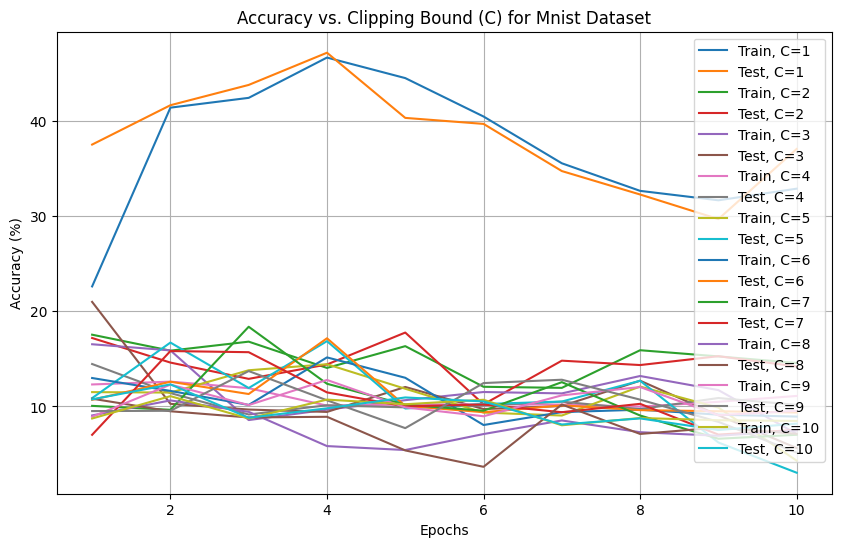

In [ ]:
#Mnist
C_values = range(1, 11)

model = Net().to(device)
num_epochs = 10
lr = 0.001
sigma = 2.0  # Assuming a fixed value for sigma

train_acc_list = []
test_acc_list = []

for C in C_values:
    print(f"\nClipping Bound: {C}")
    criterion = nn.CrossEntropyLoss()
    model = Net().to(device)

    train_acc, test_acc = DP_SGD(model, mnist_trainloader, mnist_testloader, num_epochs, criterion, lr, sigma, C)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for i, C in enumerate(C_values):
    plt.plot(epochs, train_acc_list[i], label=f"Train, C={C}")
    plt.plot(epochs, test_acc_list[i], label=f"Test, C={C}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Clipping Bound (C) for Mnist Dataset")
plt.legend()
plt.grid(True)
plt.show()


Clipping Bound: 1
Epoch 1: Train Acc: 29.91%, Test Acc: 43.54%
Epoch 2: Train Acc: 47.27%, Test Acc: 47.23%
Epoch 3: Train Acc: 45.28%, Test Acc: 43.80%
Epoch 4: Train Acc: 42.90%, Test Acc: 43.91%
Epoch 5: Train Acc: 38.52%, Test Acc: 40.58%
Epoch 6: Train Acc: 38.43%, Test Acc: 35.66%
Epoch 7: Train Acc: 38.65%, Test Acc: 39.61%
Epoch 8: Train Acc: 38.43%, Test Acc: 36.62%
Epoch 9: Train Acc: 37.10%, Test Acc: 39.78%
Epoch 10: Train Acc: 39.11%, Test Acc: 37.25%

Clipping Bound: 2
Epoch 1: Train Acc: 20.62%, Test Acc: 25.05%
Epoch 2: Train Acc: 25.86%, Test Acc: 27.53%
Epoch 3: Train Acc: 25.20%, Test Acc: 15.20%
Epoch 4: Train Acc: 18.00%, Test Acc: 13.75%
Epoch 5: Train Acc: 15.72%, Test Acc: 14.71%
Epoch 6: Train Acc: 18.11%, Test Acc: 15.78%
Epoch 7: Train Acc: 17.34%, Test Acc: 17.87%
Epoch 8: Train Acc: 14.87%, Test Acc: 11.14%
Epoch 9: Train Acc: 8.47%, Test Acc: 6.19%
Epoch 10: Train Acc: 6.52%, Test Acc: 5.72%

Clipping Bound: 3
Epoch 1: Train Acc: 12.32%, Test Acc: 17.26%


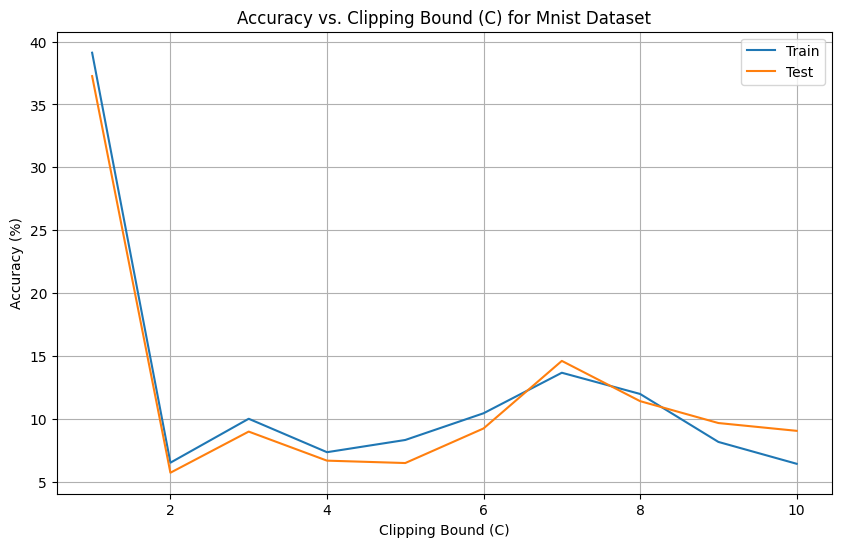

In [15]:
# Mnist
C_values = range(1, 11)

model = Net().to(device)
num_epochs = 10
lr = 0.001
sigma = 2.0  # Assuming a fixed value for sigma

train_acc_list = []
test_acc_list = []

for C in C_values:
    print(f"\nClipping Bound: {C}")
    criterion = nn.CrossEntropyLoss()
    model = Net().to(device)

    train_acc, test_acc = DP_SGD(model, mnist_trainloader, mnist_testloader, num_epochs, criterion, lr, sigma, C)

    train_acc_list.append(train_acc[-1])  # Appending the final epoch accuracy
    test_acc_list.append(test_acc[-1])  # Appending the final epoch accuracy

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_acc_list, label="Train")
plt.plot(C_values, test_acc_list, label="Test")
plt.xlabel("Clipping Bound (C)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Clipping Bound (C) for Mnist Dataset")
plt.legend()
plt.grid(True)
plt.show()


Clipping Bound: 1
Epoch 1: Train Acc: 10.92%, Test Acc: 12.27%
Epoch 2: Train Acc: 13.97%, Test Acc: 16.98%
Epoch 3: Train Acc: 16.28%, Test Acc: 15.25%
Epoch 4: Train Acc: 16.74%, Test Acc: 17.90%
Epoch 5: Train Acc: 18.33%, Test Acc: 17.97%
Epoch 6: Train Acc: 16.96%, Test Acc: 18.28%
Epoch 7: Train Acc: 18.24%, Test Acc: 18.16%
Epoch 8: Train Acc: 17.84%, Test Acc: 17.01%
Epoch 9: Train Acc: 16.47%, Test Acc: 16.79%
Epoch 10: Train Acc: 16.72%, Test Acc: 17.75%

Clipping Bound: 2
Epoch 1: Train Acc: 10.82%, Test Acc: 12.02%
Epoch 2: Train Acc: 11.61%, Test Acc: 11.27%
Epoch 3: Train Acc: 13.03%, Test Acc: 11.79%
Epoch 4: Train Acc: 12.55%, Test Acc: 12.67%
Epoch 5: Train Acc: 13.04%, Test Acc: 11.84%
Epoch 6: Train Acc: 12.40%, Test Acc: 14.05%
Epoch 7: Train Acc: 11.59%, Test Acc: 10.23%
Epoch 8: Train Acc: 10.56%, Test Acc: 10.80%
Epoch 9: Train Acc: 11.23%, Test Acc: 11.12%
Epoch 10: Train Acc: 12.00%, Test Acc: 10.35%

Clipping Bound: 3
Epoch 1: Train Acc: 10.74%, Test Acc: 10.

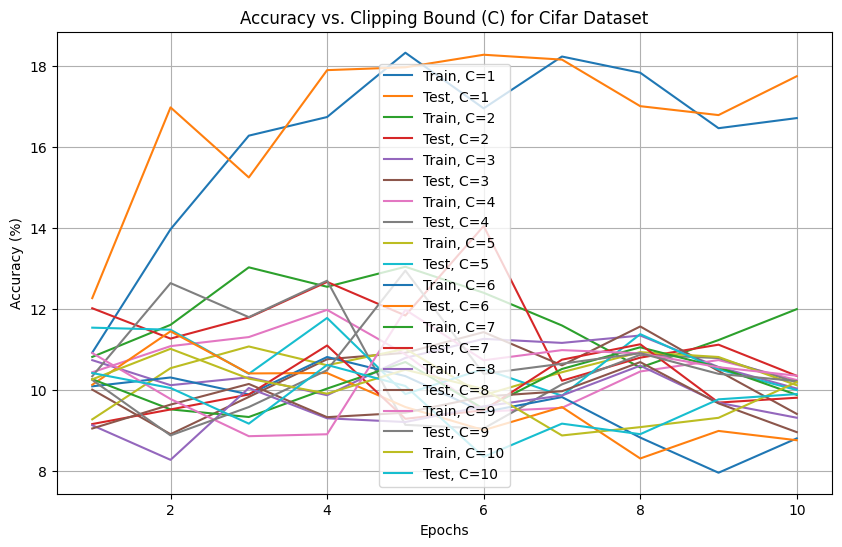

In [ ]:
#Cifar
C_values = range(1, 11)

model = Net().to(device)
num_epochs = 10
lr = 0.001
sigma = 2.0  # Assuming a fixed value for sigma

train_acc_list = []
test_acc_list = []

for C in C_values:
    print(f"\nClipping Bound: {C}")
    criterion = nn.CrossEntropyLoss()
    model = Net().to(device)

    train_acc, test_acc = DP_SGD(model, cifar_trainloader, cifar_testloader, num_epochs, criterion, lr, sigma, C)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
for i, C in enumerate(C_values):
    plt.plot(epochs, train_acc_list[i], label=f"Train, C={C}")
    plt.plot(epochs, test_acc_list[i], label=f"Test, C={C}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Clipping Bound (C) for Cifar Dataset")
plt.legend()
plt.grid(True)
plt.show()


Clipping Bound: 1
Epoch 1: Train Acc: 11.31%, Test Acc: 13.70%
Epoch 2: Train Acc: 15.67%, Test Acc: 17.20%
Epoch 3: Train Acc: 19.15%, Test Acc: 19.86%
Epoch 4: Train Acc: 18.82%, Test Acc: 18.83%
Epoch 5: Train Acc: 18.03%, Test Acc: 16.52%
Epoch 6: Train Acc: 17.16%, Test Acc: 17.51%
Epoch 7: Train Acc: 18.16%, Test Acc: 17.55%
Epoch 8: Train Acc: 18.19%, Test Acc: 18.08%
Epoch 9: Train Acc: 16.89%, Test Acc: 17.34%
Epoch 10: Train Acc: 16.05%, Test Acc: 15.49%

Clipping Bound: 2
Epoch 1: Train Acc: 11.21%, Test Acc: 12.34%
Epoch 2: Train Acc: 13.43%, Test Acc: 13.32%
Epoch 3: Train Acc: 13.51%, Test Acc: 13.18%
Epoch 4: Train Acc: 12.20%, Test Acc: 11.04%
Epoch 5: Train Acc: 11.36%, Test Acc: 10.37%
Epoch 6: Train Acc: 9.88%, Test Acc: 9.85%
Epoch 7: Train Acc: 11.83%, Test Acc: 11.15%
Epoch 8: Train Acc: 11.07%, Test Acc: 11.05%
Epoch 9: Train Acc: 9.73%, Test Acc: 8.32%
Epoch 10: Train Acc: 9.21%, Test Acc: 9.51%

Clipping Bound: 3
Epoch 1: Train Acc: 10.78%, Test Acc: 10.31%
Ep

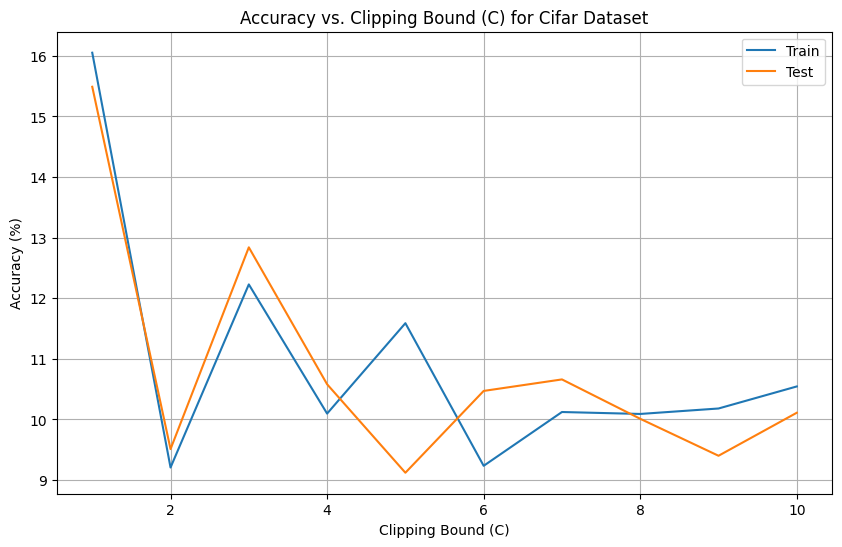

In [18]:
# Cifar
C_values = range(1, 11)

model = Net().to(device)
num_epochs = 10
lr = 0.001
sigma = 2.0  # Assuming a fixed value for sigma

train_acc_list = []
test_acc_list = []

for C in C_values:
    print(f"\nClipping Bound: {C}")
    criterion = nn.CrossEntropyLoss()
    model = Net().to(device)

    train_acc, test_acc = DP_SGD(model, cifar_trainloader, cifar_testloader, num_epochs, criterion, lr, sigma, C)

    train_acc_list.append(train_acc[-1])  # Appending the final epoch accuracy
    test_acc_list.append(test_acc[-1])  # Appending the final epoch accuracy

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_acc_list, label="Train")
plt.plot(C_values, test_acc_list, label="Test")
plt.xlabel("Clipping Bound (C)")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Clipping Bound (C) for Cifar Dataset")
plt.legend()
plt.grid(True)
plt.show()